In [1]:
import torch 
torch.cuda.empty_cache()
import torchvision 
import matplotlib.pyplot as plt 
import numpy as np 
import json 
import shutil 
import pandas as pd 
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import models
from PIL import Image
import os
import src.dataset_ as dl
import src.utility_ as utility
import src.model_ as cnn_models

In [2]:
data = open('./data/data_dict.json')
data_dict = json.load(data)

In [3]:
print('Total number of images',len(data_dict[0]))
data_dict[0]['30601258@N03/landmark_aligned_face.1.10399646885_67c7d20df9_o.jpg']

Total number of images 18404


{'gender_id': 0.0, 'age_id': 4.0}

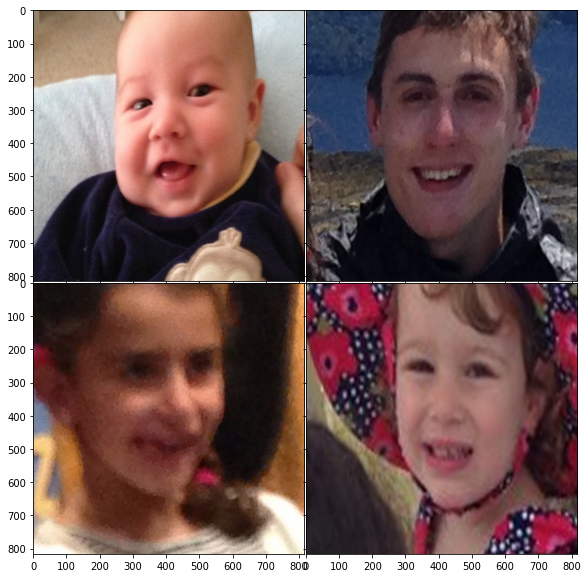

In [4]:
# visualize the images
images_list = list(data_dict[0].keys())

# shows 
utility.show_img(images_list,4)

In [5]:
Age_Gender_Dataset = dl.Gender_Age_Classifier_dataset(json_file='./data/data_dict.json',root_dir='./data/aligned',
transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((26,26))]))

In [6]:
lengths = [int(len(Age_Gender_Dataset)*0.8), len(Age_Gender_Dataset)-int(len(Age_Gender_Dataset)*0.8)]
train_Dataset, val_Dataset = torch.utils.data.random_split(Age_Gender_Dataset, lengths)

In [7]:
train_dataloader = DataLoader(train_Dataset,batch_size=2,shuffle=True)
val_dataloader = DataLoader(val_Dataset,batch_size=2,shuffle=True)

In [8]:
# Device
# Getting gpu for training 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
model = cnn_models.MobileNet_multi_task().to(device)


sample_img = torch.randn(1,3,104,104).to(device)
model(sample_img)

Using cache found in C:\Users\akgk6/.cache\torch\hub\pytorch_vision_v0.6.0


(tensor([[-0.0186, -0.1827, -0.0771,  0.1560, -0.1587, -0.1579, -0.1629,  0.0002]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[-0.2310, -0.0761,  0.2591]], device='cuda:0', grad_fn=<AddmmBackward>))

In [10]:
# Loss function
gender_criterion = torch.nn.CrossEntropyLoss()
age_criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# input parameters 
epochs = 10
best_accuracy = torch.tensor(0.0)
resume_weights = False

In [11]:
def save_checkpoint(state, is_best, checkpoint_path, best_model_path):
	"""Save checkpoint if a new best is achieved
	
	state: checkpoint we want to save 
	is_best: if this checkpoint is the best so far
	checkpoint_path: path to save checkpoint
	best_model_path: path to save best model
	"""
	
	f_path = checkpoint_path

	# save checkpoint data to the path given, checkpoint_path
	torch.save(state, f_path)

	# if it is a best model, min validation loss
	if is_best:

		best_fpath = best_model_path
		# copy that checkpoint file to best path given, best_model_path

		shutil.copyfile(f_path, best_fpath)


def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    
	# initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    
	# initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    
	# initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    
	# return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


# If exists a best model, load its weights!
if os.path.isfile(resume_weights):
	print("=> loading checkpoint '{}' ...".format(resume_weights))
	if device == "Cuda":
		checkpoint = torch.load(resume_weights)
	else:
		# Load GPU model on CPU
		checkpoint = torch.load(resume_weights,
								map_location=lambda storage,
								loc: storage)
	start_epoch = checkpoint['epoch']
	best_accuracy = checkpoint['best_accuracy']
	model.load_state_dict(checkpoint['state_dict'])
	print("=> loaded checkpoint '{}' (trained for {} epochs)".format(resume_weights,
		checkpoint['epoch']))

In [12]:
def train(dataloader,model,age_criterion,gender_criterion,optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    
    for batch,(img,age,gender) in enumerate(dataloader):
        
        
        img, age, gender = img.to(device), age.to(device), gender.to(device)
        
        # compute prediction error 
        pred = model(img)

        age_loss = age_criterion(pred[0],age.long())
        gender_loss = gender_criterion(pred[1],gender.long())

        loss = (age_loss + gender_loss)/ 2 

        # Backprop 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            age_loss,gender_loss,current = age_loss.item(),gender_loss.item(), batch*len(img)
            print(f"Age loss: {age_loss:>7f} Gender loss: {gender_loss:>7f} [{current:>5d}/{size:>5d}]")

            

    
def test(dataloader, model,valid_loss_min_input,optimizer,age_criterion,gender_criterion,epoch,checkpoint_path,best_model_path):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 

    test_age_loss,test_gender_loss, correct_age,correct_gender = 0,0,0,0

    for batch,(img,age,gender) in enumerate(dataloader):

        img,age,gender = img.to(device), age.to(device), gender.to(device)
        pred = model(img)

        test_age_loss += age_criterion(pred[0],age.long())
        test_gender_loss += gender_criterion(pred[1],gender.long())

        correct_age += (pred[0].argmax(1) == age).type(torch.float).sum().item()
        correct_gender += (pred[1].argmax(1) == gender).type(torch.float).sum().item()
        
    test_age_loss/=num_batches
    test_gender_loss /= num_batches
    correct_age /= size
    correct_gender /= size

    print(f"Test Error \n Age Accuracy: {100*correct_age:>2f} Gender Accuracy: {100*correct_gender:>2f} \n Age loss: {test_age_loss:>7f} Gender loss: {test_gender_loss:>7f}")

    combined_loss = (test_age_loss + test_gender_loss)/ 2 

    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss':combined_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }
        
    # save checkpoint   
    save_checkpoint(checkpoint, False, checkpoint_path, best_model_path)
        
    if combined_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,combined_loss))
        # save checkpoint as best model
        save_checkpoint(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = combined_loss


In [13]:
model_architecture = "mobilenet_v2"

checkpoint_path = "./models/checkpoint/{}_checkpoint.pt".format(model_architecture)
best_model_path = "./models/best_model/{}_best_model.pt".format(model_architecture)

valid_loss_min_input = np.Inf

for i in range(epochs):
    print(f'Epoch:{i+1}\n ------------------------------')
    train(train_dataloader, model,age_criterion,gender_criterion,optimizer)
    test(val_dataloader, model,valid_loss_min_input,optimizer,age_criterion,gender_criterion,i,checkpoint_path,best_model_path)


Epoch:1
 ------------------------------
Age loss: 1.974982 Gender loss: 1.044816 [    0/14723]
Age loss: 2.235940 Gender loss: 0.830658 [ 2000/14723]
Age loss: 2.116503 Gender loss: 0.583779 [ 4000/14723]
Age loss: 2.662985 Gender loss: 0.754879 [ 6000/14723]
Age loss: 2.177983 Gender loss: 2.637399 [ 8000/14723]
Age loss: 1.875345 Gender loss: 0.732559 [10000/14723]
Age loss: 1.889190 Gender loss: 2.077769 [12000/14723]
Age loss: 2.555774 Gender loss: 0.804526 [14000/14723]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 576, 1, 1])